# Performing QSO Classification using Variational Autoencoders¶

This notebook performs Quasar Classification using Variational Autoencoders. The framework used for this deep learning model is Pytorch.


## Authors

* Ash Karale
    

## Contents:

0. Introduction
1. Importing Modules
2. Data Acquisition
3. Data Processing
4. Model Definition
5. Model Training


## Versions:

Initial Version: November 2022 (Ash Karale)

Updated Version: April 2023 (Ash Karale)

In [ ]:
## GTR Make the items in the Table of Contents clickable links that bring the user to those sections.  
## See PHYS 440/540 notebooks for the syntax needed.

### 0. Introduction

In [22]:
# Do you want me to write a full-on introduction and motivation about VAEs and Deep Embedding 
# or just touch on what's being done in this notebook?

## GTR: Yes, write some introduction.  Imagine that the audience is a senior undergrad or first-year grad student.

### 1. Importing Modules

It is considered good practice to import all the modules at the beginning of a Jupyter Notebook or any Python program.
By importing all the modules at the start, we ensure that the required dependencies are present and available when we need them.

In [1]:
# Importing all required modules

# System modules allow Python programs to interact with the operating system and perform tasks 
# such as reading and writing files, managing processes, and accessing environment variables 
import os
import sys
import importlib
import pickle
import argparse
import itertools
import csv
from tqdm import tqdm
import time

# Data manipulation modules allow users to perform various operations on data,
# such as cleaning, transforming, aggregating, filtering, and visualizing data
import math
import numpy as np
import pandas as pd

# Visualization modules allow users to create visual representations of data
import matplotlib as mpl
import matplotlib.pyplot as plt
import palettable
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file, show
# pd.set_option('display.max_columns', 1000)

# Scikit-learn provides a range of supervised and unsupervised learning algorithms,
# as well as tools for model selection and data preprocessing
from sklearn import model_selection, preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, normalized_mutual_info_score, adjusted_rand_score

# Scipy is a Python library for scientific computing and technical computing
from scipy import stats
from scipy.optimize import linear_sum_assignment as linear_assignment

# Astropy is a Python library for astronomy and astrophysics
from astropy.io import fits
from astropy.table import Table

# PyTorch is an open-source machine learning library for Python that provides a range of tools
# and functions for building and training neural networks and other machine learning models
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,TensorDataset
from torch.autograd import Variable

print(sys.version)

3.9.15 | packaged by conda-forge | (main, Nov 22 2022, 08:48:25) 
[Clang 14.0.6 ]


### 2. Data Acquisition

Data Acquisition refers to the process of collecting and gathering data from various sources. It is the first step in the data analysis pipeline and involves identifying the sources of data and obtaining the data in a usable format.

This line sets the path to the data. Should another data source be used, replace the line in the next cell.

In [2]:
# Defining a variable named 'data_dir' and assigning it the string value /Users/ash/Research/Data/DELVE/ 
# This is the path to the directory where the dataset is stored on the local machine
data_dir = '/Users/ash/Research/Data/DELVE/'

# Using the display() function to display the value of the 'data_dir' variable in the output of the Jupyter Notebook
display(data_dir)

'/Users/ash/Research/Data/DELVE/'

Reading in the data file.
We use Astropy's Table to read in data files because it provides a powerful and flexible way to manipulate and work with tabular data, such as data stored in CSV, FITS, or other formats.

In [3]:
from astropy.table import Table

# Reading a data file stored in the FITS format using the Table.read() method 
# The path to the data file is constructed using the os.path.join() method to join the data_dir variable, 
# which specifies the directory containing the data file, and the filename 'fullcat15_30.fits'
data = Table.read(os.path.join(data_dir, 'fullcat15_30.fits'))

# Converting the FITS formatted data to a Pandas DataFrame using the to_pandas() method
# of the Table object for easier pandas manipulation
fc15_30 = data.to_pandas()

## GTR: I like to use a naming convention whereby one knows that something is a Pandas DataFrame.
## So, name it something like fcDF_15_30

#### Data types

Measurements fall into the following main catalogries:
- __Astromety__ -> ra, dec, proper motion and parallax
- __Photometry__ -> point and extended source photometry, in both AB magnitdues and fluxes (nJy)
- __Color__ -> Computed using the fluxes
- __Morphology__ -> 1 for extended and 0 for point-like
- __Light Curve Features__ -> Extrated on the SDSS light curves if matched
- __Redshift__ -> Both spectroscopic and photometric, wherever available

Inspecting the attributes

In [4]:
# Inspect all attributes of the chosen dataset using the info() method of the DataFrame
# to display a summary of the dataset's attributes
fc15_30.info()

## GTR: It might be useful to display these in chunks.
## Mags and errors (1-8, 10-17, 19-22)
## Morphology (23-26)
## Astrometric (28-34)
## Rough classification (35-37)
## That way someone new to this will have a better idea of what the data file contains.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8226904 entries, 0 to 8226903
Data columns (total 40 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   quick_object_id               int64  
 1   mag_auto_g                    float64
 2   magerr_auto_g                 float64
 3   mag_auto_i                    float64
 4   magerr_auto_i                 float64
 5   mag_auto_r                    float64
 6   magerr_auto_r                 float64
 7   mag_auto_z                    float64
 8   magerr_auto_z                 float64
 9   sourceid_vhs                  int64  
 10  ypetromag                     float64
 11  ypetromagerr                  float64
 12  jpetromag                     float64
 13  jpetromagerr                  float64
 14  hpetromag                     float64
 15  hpetromagerr                  float64
 16  kspetromag                    float64
 17  kspetromagerr                 float64
 18  source_id_catwise     

Visualizing the data

In [6]:
# Display descriptive statistics to describe and explore data

# The describe() method provides summary statistics for each column of the DataFrame, 
# giving insight into the distribution and spread of the data 
display(fc15_30.describe())

# The shape attribute provides information on the dimensions of the DataFrame, 
# indicating the size and shape of the data
display(fc15_30.shape)

## GTR: Similarly here, split into chunks?  Ideally don't use exponent notation for mags

,quick_object_id,mag_auto_g,magerr_auto_g,mag_auto_i,magerr_auto_i,mag_auto_r,magerr_auto_r,mag_auto_z,magerr_auto_z,sourceid_vhs,...,pmdec_error,pmra,pmra_error,radial_velocity,radial_velocity_error,classprob_dsc_combmod_galaxy,classprob_dsc_combmod_quasar,classprob_dsc_combmod_star,ra,dec
count,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,8.226904e+06,...,1.557373e+06,1.557373e+06,1.557373e+06,48494.000000,48494.000000,1.854957e+06,1.854957e+06,1.854957e+06,8.226891e+06,8.226891e+06
mean,1.094707e+13,3.621252e+01,1.845444e+01,2.265878e+01,2.736921e+00,2.480181e+01,4.699648e+00,2.248277e+01,3.002990e+00,4.731214e+11,...,3.624982e-01,8.006602e+00,3.695771e-01,15.065438,4.757164,3.015133e-02,2.166022e-02,9.447181e-01,2.257660e+01,-3.738723e+01
std,2.121984e+11,3.001855e+01,3.844732e+01,1.282219e+01,1.604855e+01,1.652845e+01,2.089137e+01,1.344820e+01,1.677004e+01,3.948849e+08,...,4.265254e-01,1.473784e+01,4.162963e-01,42.134888,2.530426,1.683584e-01,1.381415e-01,2.224325e-01,4.381642e+00,2.560200e+01
min,1.058290e+13,1.278190e+01,2.510000e-04,1.167814e+01,2.240000e-04,1.210906e+01,2.070000e-04,1.139630e+01,3.180000e-04,4.724485e+11,...,7.023000e-03,-3.656444e+02,7.576000e-03,-389.880100,0.368064,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,-8.917520e+01
25%,1.071090e+13,2.137134e+01,3.564700e-02,1.974994e+01,1.752300e-02,2.029234e+01,1.776200e-02,1.943825e+01,2.461600e-02,4.727721e+11,...,8.902700e-02,8.808007e-01,9.561100e-02,-5.499497,3.120050,0.000000e+00,0.000000e+00,9.995270e-01,1.877783e+01,-5.802477e+01
50%,1.103110e+13,2.271964e+01,1.067540e-01,2.084213e+01,4.437600e-02,2.150048e+01,4.755800e-02,2.049579e+01,6.098700e-02,4.731158e+11,...,2.110240e-01,5.454478e+00,2.270870e-01,12.312459,4.293459,0.000000e+00,0.000000e+00,9.999640e-01,2.261313e+01,-4.380240e+01
75%,1.112821e+13,2.406641e+01,2.546230e-01,2.170479e+01,9.042500e-02,2.257661e+01,1.152750e-01,2.128124e+01,1.132440e-01,4.734579e+11,...,4.546690e-01,1.218151e+01,4.782410e-01,31.317938,5.783195,0.000000e+00,0.000000e+00,9.999900e-01,2.643880e+01,-8.987319e+00
max,1.122840e+13,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,4.738183e+11,...,3.353055e+00,6.766674e+02,3.366169e+00,761.085100,39.556290,1.000000e+00,1.000000e+00,1.000000e+00,3.000000e+01,1.441188e+00


(8226904, 40)

### 3. Data Processing

Data Processing refers to the process of transforming raw data into a form that is suitable for analysis. It involves a series of steps that may include data cleaning, data integration, data transformation, data reduction, and data visualization.

Create a subset with the maximal number of objects where the data values are meaningful.
Specifically-
* Merge the Star, Galaxy, and QSO attributes
* remove features that we don't want to use and/or identify only the features that we want to keep
* remove objects that don't have one or more entries for the features (and/or impute those values)

In [7]:
# Converting the list 'fc15_30' to a Pandas DataFrame using the pd.DataFrame() method
fc15_30 = pd.DataFrame(fc15_30)

# Replacing the string values of the columns named 'classprob_dsc_combmod_star', 'classprob_dsc_combmod_galaxy',
# and 'classprob_dsc_combmod_quasar' with numerical values 0, 1, and 2, respectively.
fc15_30 = fc15_30.replace({'classprob_dsc_combmod_star': 0,
                           'classprob_dsc_combmod_galaxy': 1,
                           'classprob_dsc_combmod_quasar': 2})

# Merging the class probability attributes of galaxies, quasars, and stars into a single 'class' attribute 
# based on the highest probability value

# We use the apply() method to apply a lambda function to each row of the DataFrame 
# The lambda function compares the class probabilities for each object and assigns the object to one of the
# classes based on which class probability is highest
fc15_30['class'] = fc15_30[['classprob_dsc_combmod_galaxy', 'classprob_dsc_combmod_quasar',
                            'classprob_dsc_combmod_star']].apply(
    lambda row: 0 if row['classprob_dsc_combmod_star'] > row['classprob_dsc_combmod_galaxy'] and
    row['classprob_dsc_combmod_star'] > row['classprob_dsc_combmod_quasar']
    else 1 if row['classprob_dsc_combmod_galaxy'] > row['classprob_dsc_combmod_quasar'] else 2, axis=1)

## GTR: The above isn't readable, so the user has to trust that it is doing the right thing.  
## At least put in some line breaks.  But ideally get rid of the lambda function.

In [8]:
# Cut RA, Dec, and Object IDs
# Cut the errors

## GTR: If you do this sooner, it may satisfy what I asked for above.

# Create a list of feature column names for the dataset
# These features include photometric magnitudes, extended class, proper motion, and radial velocity
fc_list = [
    'mag_auto_g', 'mag_auto_i', 'mag_auto_r', 'mag_auto_z',  # Magnitudes in g, i, r, and z bands from AUTO photometry
    'ypetromag', 'jpetromag', 'hpetromag', 'kspetromag',  # Magnitudes in Y, J, H, and Ks bands from Petrosian photometry
    'w1mpro', 'w2mpro',  # Magnitudes in WISE 1 and WISE 2 bands
    'extended_class_g', 'extended_class_r', 'extended_class_i', 'extended_class_z',  # Extended class in g, r, i, and z bands
    'pm', 'pmdec', 'pmra',  # Total proper motion, proper motion in declination, and proper motion in right ascension
    'radial_velocity',  # Radial velocity of the objects
    'class'  # Classification of the objects (e.g., star, galaxy, QSO)
]


In [9]:
# Selecting a subset of columns from the DataFrame 'fc15_30' based on the list 'fc_list'
# Dropping rows containing missing values using the dropna() method and assigning
# the resulting DataFrame to a new variable 'fc1530_df'
fc1530_df = fc15_30[fc_list].dropna()

# Outputting the number of non-null values for each column in the 'fc1530_df' DataFrame using the count() method
fc1530_df.count()

# Outputting summary statistics for each column in the 'fc1530_df' DataFrame using the describe() method
fc1530_df.describe()

## GTR: Need some idea of the impact of dropna.  E.g., should we impute instead?

,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,ypetromag,jpetromag,hpetromag,kspetromag,w1mpro,w2mpro,extended_class_g,extended_class_r,extended_class_i,extended_class_z,pm,pmdec,pmra,radial_velocity,class
count,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.000000,3878.0
mean,15.074490,98.106126,80.541600,92.838422,13.127619,12.830717,12.466560,12.330945,12.222189,12.255956,0.011088,-7.018824,-8.901238,-8.335740,26.224141,-10.997442,11.025977,0.846028,0.0
std,2.050147,8.648432,34.817644,22.005637,0.480781,0.478690,0.503524,0.575930,0.634424,0.659612,0.293741,3.739231,0.960286,2.377505,31.937372,22.858178,30.705113,38.378949,0.0
min,13.586863,13.888441,13.949226,13.643000,10.535904,10.514173,10.439587,9.902435,8.483000,8.366000,-9.000000,-9.000000,-9.000000,-9.000000,0.240833,-290.918027,-225.113084,-384.349550,0.0
25%,14.493887,99.000000,99.000000,99.000000,12.857927,12.559476,12.171757,12.005545,11.890250,11.918250,0.000000,-9.000000,-9.000000,-9.000000,9.880825,-16.326417,-1.763480,-16.231873,0.0
50%,14.873382,99.000000,99.000000,99.000000,13.215891,12.910459,12.528939,12.414473,12.329000,12.380000,0.000000,-9.000000,-9.000000,-9.000000,17.674724,-7.371130,6.420270,2.919407,0.0
75%,15.402130,99.000000,99.000000,99.000000,13.489128,13.185145,12.831912,12.753021,12.678750,12.729000,0.000000,-9.000000,-9.000000,-9.000000,30.157518,-1.259276,18.508044,21.052890,0.0
max,99.000000,99.000000,99.000000,99.000000,14.367229,13.792408,13.527734,13.606899,13.413000,13.463000,3.000000,3.000000,3.000000,3.000000,421.889700,132.925068,394.791703,234.312870,0.0


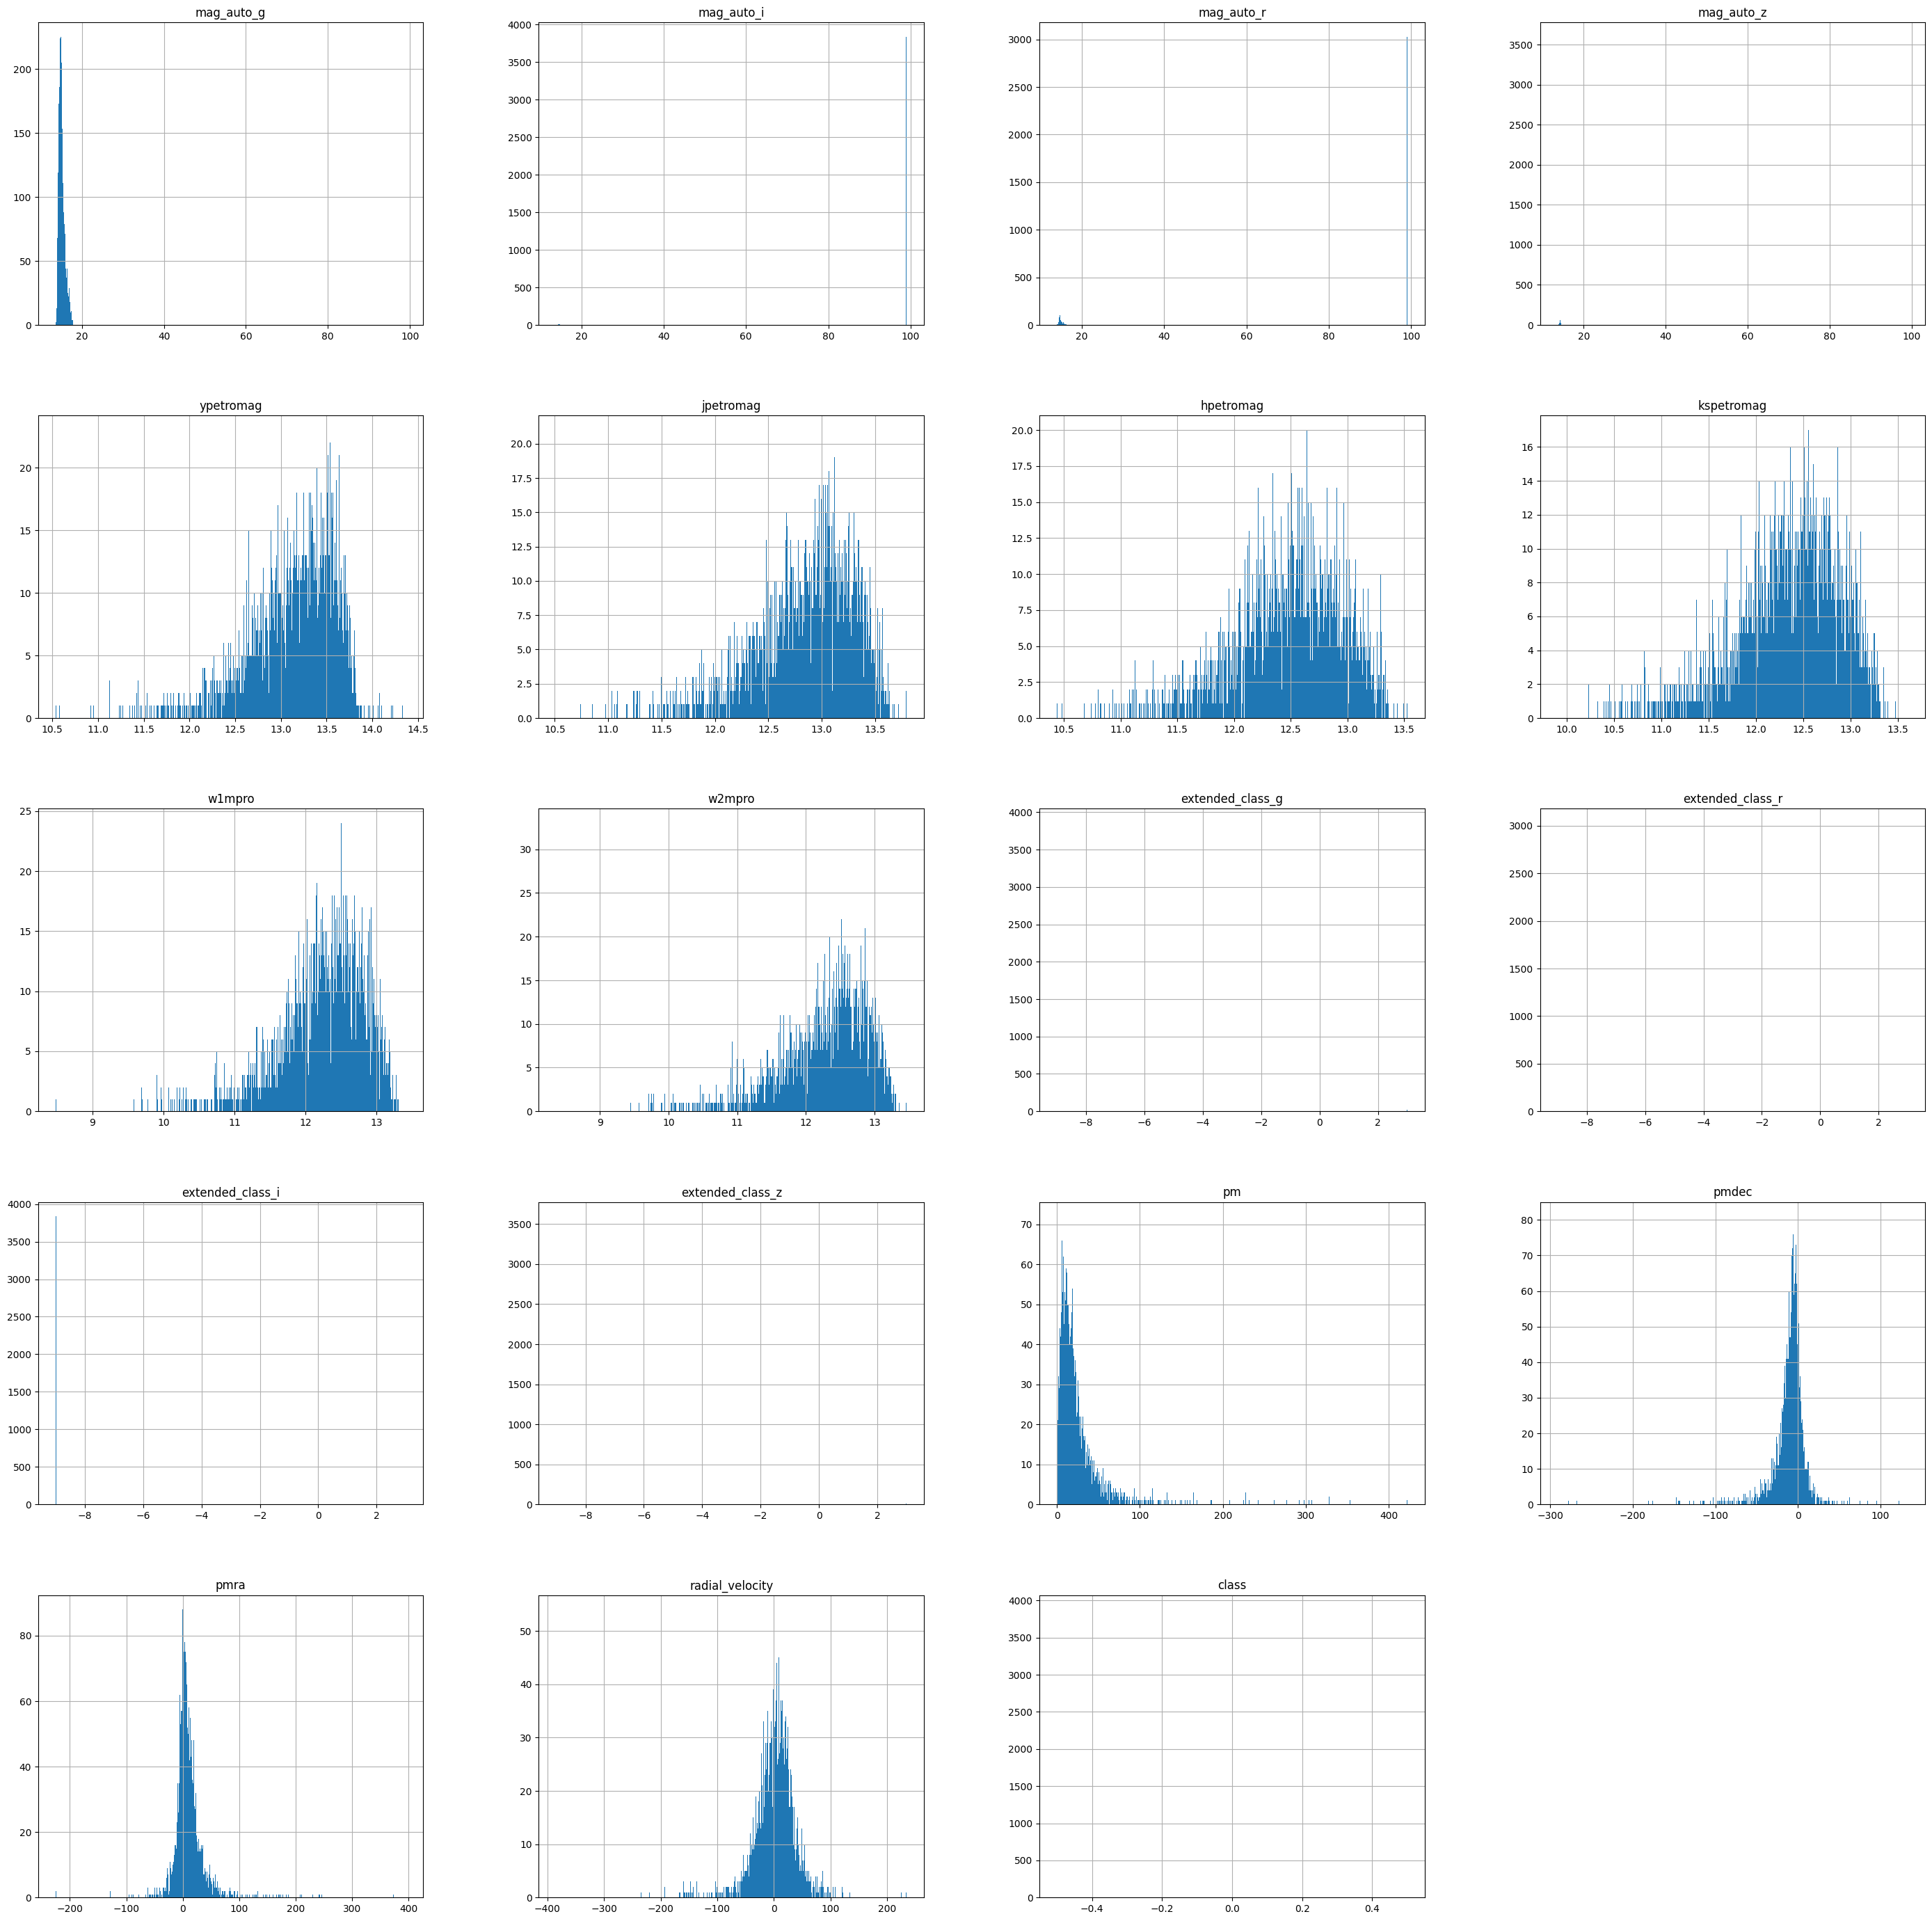

(3878, 19)

In [10]:
# Visualize the distribution of the data in the 'fc1530_df' DataFrame using histograms.

fc1530_df.hist(figsize = [35, 35], bins=1000)
plt.show()
display(fc1530_df.shape)

## GTR: This is how Djordje does it, which is minimally useful.  But is it also very compact.
## Leave it for now, but it might be nice to do something better later.

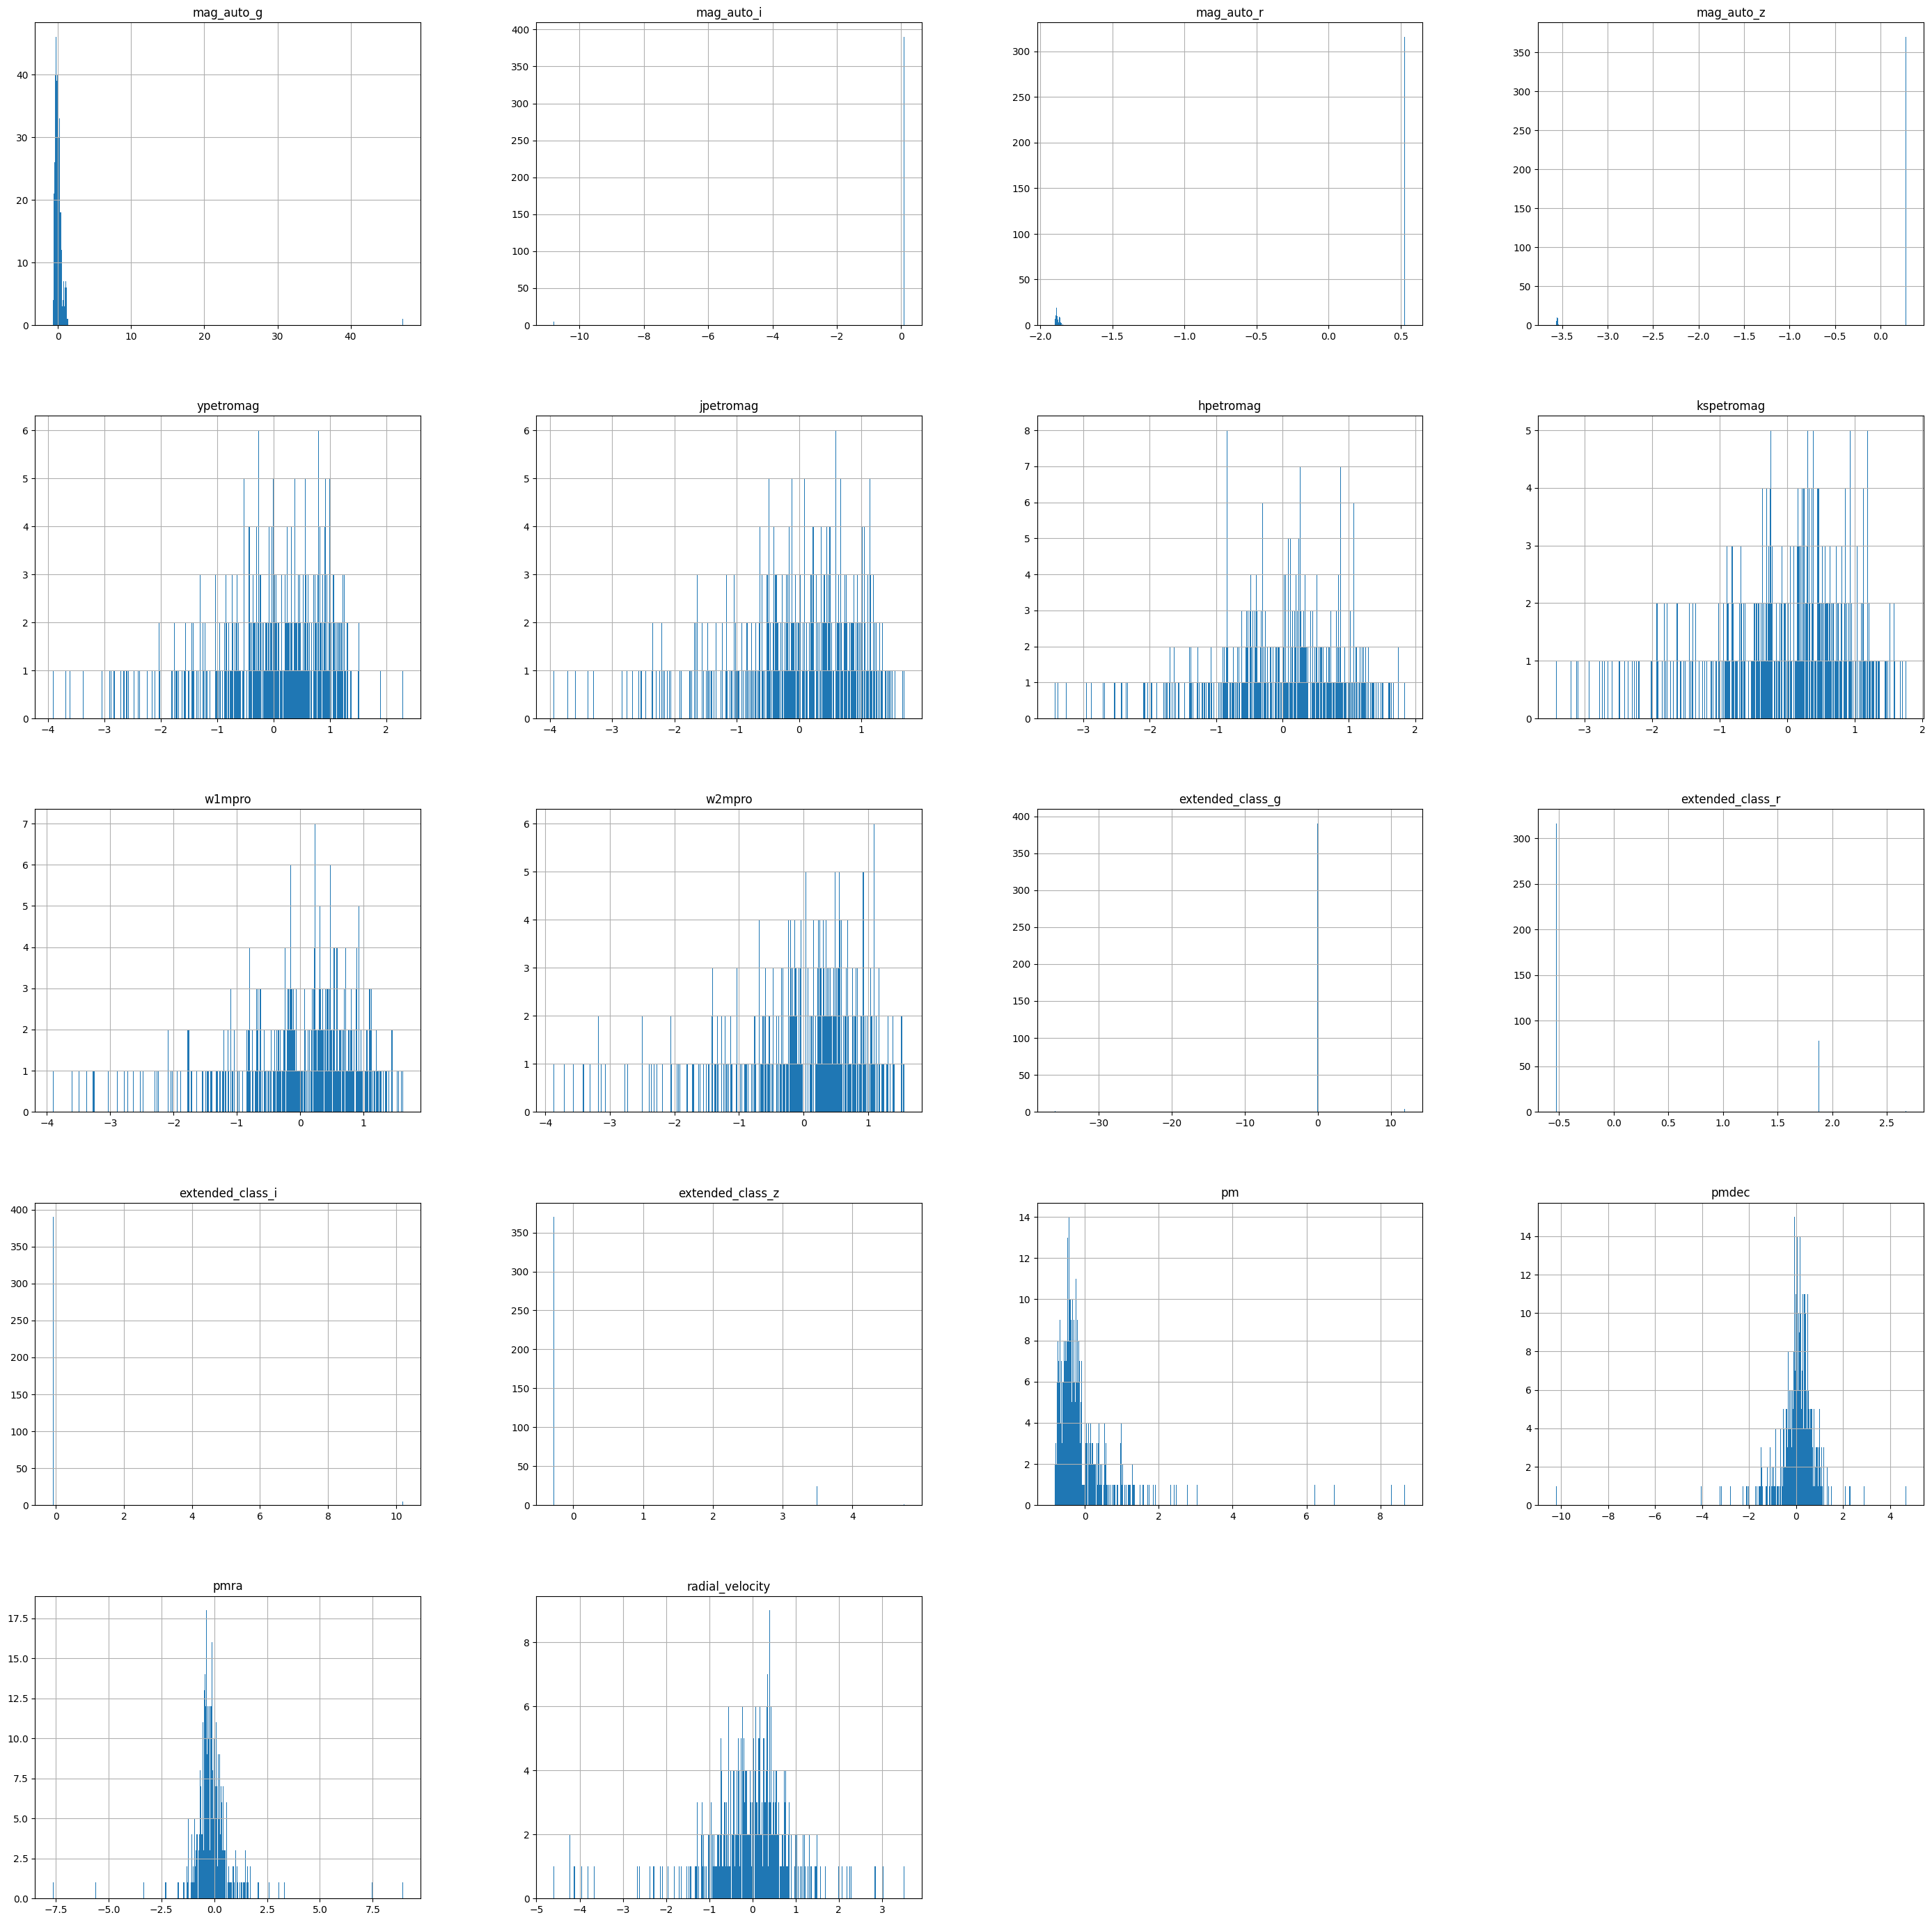

(2714, 18)

(769, 18)

(395, 18)

In [11]:
# Standardizing and Scaling
# Splitting without stratification

# Set X to the entire DataFrame
X = fc1530_df

# Remove the 'class' column from X as it is the target variable
X = X.drop(['class'], axis=1)
# Set y to the 'class' column of the DataFrame
y = fc1530_df['class']

# Split the dataset into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=123)
# Further split the testing set into testing and validation sets (66% validation, 34% testing)
X_test, X_val, y_test, y_val = model_selection.train_test_split(X_test, y_test, test_size=0.66, random_state=123)

# Initialize a StandardScaler object
scaler = StandardScaler()
# Fit the scaler on the training data
scaler.fit(X_train)

## GTR: Worth taking a second to remind the user what that does.
## We may want to do something different (e.g., minmax)  Or maybe something different for only some columns.

# Transform the training, validation, and testing sets using the fitted scaler
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Plot histograms of the standardized test set features
pd.DataFrame(X_test, columns=X.columns).hist(figsize=[35, 35], bins=500)
plt.show()

# Display the shapes of the training, validation, and testing sets
display(X_train.shape, X_val.shape, X_test.shape)

### 4. Model Definition

Model architecture refers to the overall structure and design of a machine learning model. It includes the number and type of layers, the number of neurons or units in each layer, the activation functions used in each layer, the optimization algorithm used for training, and other design choices that are made when creating a model.

As we proceed with unsupervised classification, it is necessary to have functions to evaluate the performance of the models and the quality of the clustering results. 
The following functions are commonly used for evaluation:

In [12]:
# Function to calculate accuracy
def acc_f(y_true, y_pred):
    y_true = y_true.astype(np.int64)  # Convert true labels to integer
    assert y_pred.size == y_true.size  # Assert that true and predicted label arrays have the same size
    D = max(y_pred.max(), y_true.max()) + 1  # Get the maximum label value plus 1
    ## GTR: Why plus 1?
    w = np.zeros((D, D), dtype=np.int64)  # Create a zeros matrix with dimensions DxD
    for i in range(y_pred.size):  # Loop through predicted labels
        w[y_pred[i], y_true[i]] += 1  # Increment the corresponding element in the w matrix
    ind = np.transpose(np.asarray(linear_assignment(w.max() - w)))  # Apply the algorithm and transpose the result
    ## GTR: What algorithm?  Reference the function below.  
    ## Maybe say what this is the same as in Scikit-Learn (or how it is different)?
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size  # Calculate the accuracy

# Functions for calculating normalized mutual information (NMI) and adjusted Rand index (ARI)
nmi_f = normalized_mutual_info_score
ari_f = adjusted_rand_score

# Function to correct label assignment for unsupervised classification
## GTR: Meaning what exactly?
def label_assignement(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)  # Calculate confusion matrix
    original_labels = np.array([0, 1, 2])  # Original labels (0: Star, 1: Galaxy, 2: QSO)
    unsupervised_labels = np.array([np.argmax(cf[0, :]), np.argmax(cf[1, :]), np.argmax(cf[2, :])])  # Get the corresponding unsupervised labels
    y_pred_copy = y_pred.copy()  # Create a copy of the predicted labels
    for i, j in zip(original_labels, unsupervised_labels):  # Loop through original and unsupervised labels
        y_pred_copy[y_pred == j] = i  # Replace unsupervised labels with original labels
    y_pred_corr = y_pred_copy  # Store the corrected predicted labels
    return y_pred_corr  # Return the corrected predicted labels


Custom Variational Deep Embedding (VaDE)

Variational Deep Embedding (VaDE) is a deep learning model used for unsupervised clustering and dimensionality reduction. VaDE is an extension of Variational Autoencoder (VAE) that incorporates a Gaussian mixture model (GMM) to learn the latent space representation of the input data.

In [ ]:
## GTR: We might include a sort of appendix explaining what a VAE is.  
## Or another notebook showing what happens if we use a simple VAE instead of the VaDE.
## I'm not necessarily a fan of GMM for classification. 
## More specifically, I don't think that this is the optimal approach:
## https://ui.adsabs.harvard.edu/abs/2011ApJ...729..141B/abstract
## Which isn't quite the same thing as saying that I don't think that VaDE is.  It might be.

In [18]:
## GTR: I'm still interested in having a notebook that compares building an NN in keras vs. torch.
## Say a simple Autoencoder.  Maybe a variant too.

# Define a function to build a neural network
def buildNetwork(layers, activation="relu", dropout=0, is_bn=False):
    net = []  # Initialize an empty list to hold the network layers
    for i in range(1, len(layers)):  # Loop through the layers
        net.append(nn.Linear(layers[i-1], layers[i]))  # Add a linear layer
        if is_bn:  # Check if batch normalization is required
            net.append(nn.BatchNorm1d(layers[i]))  # Add batch normalization layer
        # Add activation function layers based on the specified type
        if activation=="relu":
            net.append(nn.ReLU())
        elif activation=="sigmoid":
            net.append(nn.Sigmoid())
        elif activation == "prelu":
            net.append(nn.PReLU())
        elif activation == "elu":
            net.append(nn.ELU())
        if dropout > 0:  # Check if dropout is required
            net.append(nn.Dropout(dropout))  # Add dropout layer
    return nn.Sequential(*net)  # Return the network as a PyTorch sequential model

# Define a function to adjust the learning rate during training
def adjust_learning_rate(init_lr, optimizer, epoch):
    lr = max(init_lr * (0.9 ** (epoch//10)), 0.0002)  # Calculate the new learning rate
    for param_group in optimizer.param_groups:  # Update the learning rate in the optimizer
        param_group["lr"] = lr
    return lr

# Define a function to calculate the log likelihood of samples from a unit Gaussian distribution
def log_likelihood_samples_unit_gaussian(samples):
    return -0.5*math.log(2*math.pi)*samples.size()[1] - torch.sum(0.5*(samples)**2, 1)

# Define a function to calculate the log likelihood of samples given the mean and variance
def log_likelihood_samplesImean_sigma(samples, mu, logvar):
    return -0.5*log2pi*samples.size()[1] - torch.sum(0.5*(samples-mu)**2/torch.exp(logvar) + 0.5*logvar, 1)

## GTR: Hard to follow this.  Not sure that you can do anything about it.
## But maybe some illustration of what it is doing would be good. 
## Could just be a link to something like this (simpler would be better)
## https://medium.com/machine-intelligence-and-deep-learning-lab/variational-deep-embedding-403fb476ed7f
## or their video https://www.youtube.com/watch?v=o0fQXZ9ReLQ


# Define the VaDE (Variational Deep Embedding) class, which inherits from PyTorch's nn.Module
class VaDE(nn.Module):
    # Initialize the class with default parameters
    def __init__(self, input_dim=18, z_dim=3, n_centroids=3, binary=False,
                 encodeLayer=[18, 6], decodeLayer=[6, 18], activation="elu", dropout=0, is_bn=False):
        super(self.__class__, self).__init__()  # Call the superclass constructor (nn.Module)
        self.z_dim = z_dim  # Set the latent dimension size
        self.n_centroids = n_centroids  # Set the number of centroids for clustering
        # Build the encoder network
        self.encoder = buildNetwork([input_dim] + encodeLayer, activation=activation, 
                                    dropout=dropout, is_bn=binary)
        # Build the decoder network
        self.decoder = buildNetwork([z_dim] + decodeLayer, activation=activation, dropout=dropout, is_bn=is_bn)
        
        # Define linear layers for encoding and decoding without activation functions;
        # this is because activation functions are applied later in the forward pass
        self._enc_mu = nn.Linear(encodeLayer[-1], z_dim)
        self._enc_log_sigma = nn.Linear(encodeLayer[-1], z_dim)
        self._dec_mu = nn.Linear(decodeLayer[-1], input_dim)
        self._dec_log_sigma = nn.Linear(decodeLayer[-1], input_dim)
        
        self._dec_act = None
        self.binary = binary
        if binary:
            self._dec_act = nn.Sigmoid()  # Use sigmoid activation for binary data

        self.create_gmmparam(n_centroids, z_dim)  # Create Gaussian Mixture Model parameters

    # Function to create Gaussian Mixture Model parameters
    def create_gmmparam(self, n_centroids, z_dim):
        self.theta_p = nn.Parameter(torch.ones(n_centroids)/n_centroids)  # Mixing coefficients
        self.u_p = nn.Parameter(torch.zeros(z_dim, n_centroids))  # Means
        self.lambda_p = nn.Parameter(torch.ones(z_dim, n_centroids))  # Variances

    # Function to initialize Gaussian Mixture Model parameters
    def initialize_gmm(self, dataloader):
        use_cuda = torch.cuda.is_available()  # Check if GPU is available
        if use_cuda:
            self.cuda()  # Move the model to GPU if available
        self.eval()  # Set the model to evaluation mode

        data = []  # Initialize an empty list to store latent variable data
        # Loop through the dataloader to get input data
        for batch_idx, (inputs, _) in enumerate(dataloader):
            inputs = inputs.view(inputs.size(0), -1).float()  # Flatten and convert the inputs to float
            if use_cuda:
                inputs = inputs.cuda()  # Move inputs to GPU if available
            inputs = Variable(inputs)  # Convert inputs to PyTorch Variable
            z, outputs, out_logvar, mu, logvar = self.forward(inputs)  # Forward pass through the model
            data.append(z.data.cpu().numpy())  # Append the latent variable data to the list
        data = np.concatenate(data)  # Concatenate the latent variable data
        # Fit a Gaussian Mixture Model to the data
        gmm = GaussianMixture(n_components=self.n_centroids, covariance_type='diag')
        gmm.fit(data)
        # Update the means and variances with the fitted GMM parameters
        self.u_p.data.copy_(torch.from_numpy(gmm.means_.T.astype(np.float32)))  # Transpose required due to different shape conventions
        self.lambda_p.data.copy_(torch.from_numpy(gmm.covariances_.T.astype(np.float32)))

    def gmm_kmeans_cluster(self, dataloader):
        use_cuda = torch.cuda.is_available()  # Check if GPU is available
        # use_cuda = False
        if use_cuda:  # If GPU is available, move the model to GPU
            self.cuda()

        self.eval()  # Set the model to evaluation mode
        data = []  # Initialize an empty list to store the data
        Y = []  # Initialize an empty list to store the labels
        # Iterate through the dataloader, get input data and labels
        for batch_idx, (inputs, y) in enumerate(dataloader):
            inputs = inputs.view(inputs.size(0), -1).float()  # Flatten the input data
            if use_cuda:  # If GPU is available, move the inputs to GPU
                inputs = inputs.cuda()
            inputs = Variable(inputs)  # Wrap the inputs in a PyTorch Variable
            _, _, _, mu, _ = self.forward(inputs)  # Perform a forward pass through the model and get the latent mean
            data.append(mu.data.cpu().numpy())  # Append the latent mean to the data list
            Y.append(y.numpy())  # Append the labels to the Y list
        data = np.concatenate(data)  # Concatenate the data to create a single array
        Y = np.concatenate(Y).flatten()  # Concatenate the labels to create a single flattened array
        # Fit a Gaussian Mixture Model with the given number of clusters and covariance type
        gmm = GaussianMixture(n_components=self.n_centroids, covariance_type='full', 
                              init_params='kmeans', n_init=50)
        gmm.fit(data)
        y_pred_gmm = gmm.predict(data)  # Predict the cluster assignments using the GMM
        # Calculate the accuracy, NMI, and ARI scores for the GMM
        acc = np.round(acc_f(Y, y_pred_gmm), 5)
        nmi = np.round(nmi_f(Y, y_pred_gmm), 5)
        ari = np.round(ari_f(Y, y_pred_gmm), 5)
        print('GMM fit of AutoEncoder embedding: acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari))

        # Fit a K-Means clustering model with the given number of clusters
        km = KMeans(n_clusters=self.n_centroids, n_init=20)
        y_pred_kmeans = km.fit_predict(data)  # Predict the cluster assignments using K-Means
        # Calculate the accuracy, NMI, and ARI scores for K-Means
        acc = np.round(acc_f(Y, y_pred_kmeans), 5)
        nmi = np.round(nmi_f(Y, y_pred_kmeans), 5)
        ari = np.round(ari_f(Y, y_pred_kmeans), 5)
        print('Kmeans fit of AutoEncoder embedding: acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari))

    def reparameterize(self, mu, logvar):
        if self.training:  # Check if the model is in training mode
            std = logvar.mul(0.5).exp_()  # Calculate the standard deviation from the log variance
            eps = Variable(std.data.new(std.size()).normal_())  # Sample epsilon from a normal distribution
            # Use the reparameterization trick to sample from the latent space
            return eps.mul(std).add_(mu)
        else:  # If the model is not in training mode, return the mean as the latent space representation
            return mu

    def forward(self, x):
        h = self.encoder(x)  # Encode the input into a hidden representation
        mu = self._enc_mu(h)  # Calculate the mean of the latent space distribution
        logvar = self._enc_log_sigma(h)  # Calculate the log variance of the latent space distribution
        z = self.reparameterize(mu, logvar)  # Sample from the latent space distribution
        x_mu, x_logvar = self.decode(z)  # Decode the latent space representation back to input space
        return z, x_mu, x_logvar, mu, logvar

    def decode(self, z):
        h = self.decoder(z)  # Decode the latent space representation into a hidden representation
        x_mu = self._dec_mu(h)  # Calculate the mean of the input space distribution
        x_logvar = self._dec_log_sigma(h)  # Calculate the log variance of the input space distribution
        if self._dec_act is not None:  # Check if the decoder activation function is defined
            x_mu = self._dec_act(x_mu)  # Apply the decoder activation function
        return x_mu, x_logvar

    def get_gamma(self, z, z_mean, z_log_var):
        Z = z.unsqueeze(2).expand(z.size()[0], z.size()[1], self.n_centroids)  # Expand z to match the dimensions for gamma calculation
        z_mean_t = z_mean.unsqueeze(2).expand(z_mean.size()[0], z_mean.size()[1], self.n_centroids)
        z_log_var_t = z_log_var.unsqueeze(2).expand(z_log_var.size()[0], z_log_var.size()[1], self.n_centroids)
        u_tensor3 = self.u_p.unsqueeze(0).expand(z.size()[0], self.u_p.size()[0], self.u_p.size()[1])  # Expand u_p tensor
        lambda_tensor3 = self.lambda_p.unsqueeze(0).expand(z.size()[0], self.lambda_p.size()[0], self.lambda_p.size()[1])
        theta_tensor2 = self.theta_p.unsqueeze(0).expand(z.size()[0], self.n_centroids)  # Expand theta_p tensor

        # Calculate p_c_z, the probability of each cluster given the latent space representation
        p_c_z = torch.exp(torch.log(theta_tensor2) - torch.sum(0.5*torch.log(2*math.pi*lambda_tensor3) +
                                                               (Z-u_tensor3)**2/(2*lambda_tensor3), dim=1)) + 1e-10
        gamma = p_c_z / torch.sum(p_c_z, dim=1, keepdim=True)  # Normalize p_c_z to get the soft assignment of each data point to the clusters

        return gamma

    # Define the loss function for the VaDE model
    def loss_function(self, recon_x_mu, recon_x_logvar, x, z, z_mean, z_log_var):
        alpha = 3e-3  # Weight factor for the loss components

        # Pre-processing and reshaping of tensors for computation
        Z = z.unsqueeze(2).expand(z.size()[0], z.size()[1], self.n_centroids)  # NxDxK
        z_mean_t = z_mean.unsqueeze(2).expand(z_mean.size()[0], z_mean.size()[1], self.n_centroids)
        z_log_var_t = z_log_var.unsqueeze(2).expand(z_log_var.size()[0], z_log_var.size()[1], self.n_centroids)
        u_tensor3 = self.u_p.unsqueeze(0).expand(z.size()[0], self.u_p.size()[0], self.u_p.size()[1])  # NxDxK
        lambda_tensor3 = self.lambda_p.unsqueeze(0).expand(z.size()[0], self.lambda_p.size()[0], self.lambda_p.size()[1])
        theta_tensor2 = self.theta_p.unsqueeze(0).expand(z.size()[0], self.n_centroids)  # NxK

        # Compute p(c|z) using Gaussian Mixture Model
        p_c_z = torch.exp(torch.log(theta_tensor2) - torch.sum(0.5 * torch.log(2 * math.pi * lambda_tensor3) +
            (Z - u_tensor3)**2 / (2 * lambda_tensor3), dim=1)) + 1e-10  # NxK
        gamma = p_c_z / torch.sum(p_c_z, dim=1, keepdim=True)  # NxK

        # Compute the Binary Cross Entropy (BCE) or Gaussian Negative Log Likelihood (GNLL) loss
        if self.binary:
            BCE = -torch.sum(x * torch.log(torch.clamp(recon_x_mu, min=1e-10)) + (1 - x) * torch.log(torch.clamp(1 - recon_x_mu, min=1e-10)), 1)
        else:
            BCE = torch.sum(0.5 * math.log(2 * math.pi) + 0.5 * recon_x_logvar + 0.5 * (x - recon_x_mu)**2 / torch.exp(recon_x_logvar), 1)

        # Compute the other loss components
        logpzc = torch.sum(0.5 * gamma * torch.sum(math.log(2 * math.pi) + torch.log(lambda_tensor3) +
            torch.exp(z_log_var_t) / lambda_tensor3 + (z_mean_t - u_tensor3)**2 / lambda_tensor3, dim=1), dim=1)
        qentropy = -0.5 * torch.sum(1 + z_log_var + math.log(2 * math.pi), 1)
        logpc = -torch.sum(torch.log(theta_tensor2) * gamma, 1)
        logqcx = torch.sum(torch.log(gamma) * gamma, 1)

        # Compute the total loss and return gamma and loss
        loss = torch.mean(alpha * BCE + logpzc + qentropy + logpc + logqcx)
        return gamma, loss

    def save_model(self, path):
        torch.save(self.state_dict(), path)  # Save the model's state dictionary to the specified path
        
    # The following commented function is an alternative way to save the model,
    # which is not used in this code.
    # def save_model(self):
        # path = "/Users/ash/Research/Git/QSO_Selection/data/NNCheckpoints"
        # torch.save(self.state_dict(), path)
        
    def load_model(self, path):
        # Load the pre-trained model's state dictionary
        pretrained_dict = torch.load(path, map_location=lambda storage, loc: storage)
        model_dict = self.state_dict()  # Get the current model's state dictionary
        # Filter out the keys that are not in the current model's state dictionary
        pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
        model_dict.update(pretrained_dict)  # Update the current model's state dictionary
        self.load_state_dict(model_dict)  # Load the updated state dictionary into the model

    def fit(self, trainloader, validloader, model_name, save_inter=200, lr=0.001, batch_size=128, num_epochs=50,
            visualize=False, anneal=False):
        use_cuda = torch.cuda.is_available()  # Check if GPU is available
        # use_cuda = False  # Uncomment to force the use of CPU instead of GPU
        if use_cuda:
            self.cuda()  # Move the model to GPU if available

        # Create an Adam optimizer for model's trainable parameters with the specified learning rate
        optimizer = Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=lr)

        # Open a log file to save training progress
        logfile = open('/Users/ash/Research/Git/QSO_Selection/data/NNCheckpoints' + model_name + 'cluster_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['epoch', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()

        # Loop through each epoch
        for epoch in range(num_epochs):
            # Set the model to training mode
            self.train()
            if anneal:
                # Adjust the learning rate based on the current epoch
                epoch_lr = adjust_learning_rate(lr, optimizer, epoch)
            train_loss = 0.0

            # Loop through the training data
            for batch_idx, (inputs, _) in enumerate(trainloader):
                inputs = inputs.view(inputs.size(0), -1).float()  # Flatten the inputs
                if use_cuda:
                    inputs = inputs.cuda()  # Move inputs to GPU if available
                optimizer.zero_grad()  # Reset the optimizer's gradient
                inputs = Variable(inputs)  # Wrap the inputs as a PyTorch Variable
                
                # Forward pass through the model
                z, outputs, out_logvar, mu, logvar = self.forward(inputs)
                # Compute the loss using the model's loss_function method
                _, loss = self.loss_function(outputs, out_logvar, inputs, z, mu, logvar)
                train_loss += loss.data.item() * len(inputs)
                loss.backward()  # Backpropagate the gradients
                optimizer.step()  # Update the model's parameters


            # Validate the model
            if epoch % save_inter == 0:
                self.eval()  # Set the model to evaluation mode
                valid_loss = 0.0  # Initialize the validation loss
                total_num = 0  # Initialize the total number of samples processed
                Y = []  # Initialize the list to store true labels
                Y_pred = []  # Initialize the list to store predicted labels
                # Iterate through the validation data loader
                for batch_idx, (inputs, labels) in enumerate(validloader):
                    inputs = inputs.view(inputs.size(0), -1).float()  # Flatten the inputs
                    if use_cuda:  # Check if GPU is available
                        inputs = inputs.cuda()  # Move the inputs to GPU
                    inputs = Variable(inputs)  # Wrap the inputs in a PyTorch Variable
                    # Disable gradient computation to save memory during evaluation
                    with torch.no_grad():
                        z, outputs, out_logvar, mu, logvar = self.forward(inputs)  # Forward pass through the model
                    gamma, loss = self.loss_function(outputs, out_logvar, inputs, z, mu, logvar)  # Compute the loss
                    valid_loss += loss.data.item() * len(inputs)  # Update the validation loss
                    total_num += len(inputs)  # Update the total number of samples processed
                    Y.append(labels.numpy())  # Append true labels to the list
                    # Append predicted labels to the list
                    Y_pred.append(np.argmax(gamma.data.cpu().numpy(), axis=1))

                valid_loss = valid_loss/total_num  # Calculate the average validation loss
                Y = np.concatenate(Y).flatten()  # Flatten the true labels
                Y_pred = np.concatenate(Y_pred).flatten()  # Flatten the predicted labels

                # Compute evaluation metrics: accuracy, NMI, and ARI
                acc = np.round(acc_f(Y, Y_pred), 5)
                nmi = np.round(nmi_f(Y, Y_pred), 5)
                ari = np.round(ari_f(Y, Y_pred), 5)
                loss = np.round(valid_loss, 5)
                logdict = dict(epoch=epoch, acc=acc, nmi=nmi, ari=ari, loss=loss)
                logwriter.writerow(logdict)
                # Print the evaluation results for the current epoch
                print('Epoch %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (epoch, acc, nmi, ari), ' ; loss=', loss)
                if acc>0.973:
                    # Save the model if the accuracy is greater than 0.973
                    # torch.save(self.state_dict(), "./NNcheckpoints/Vade_vade{:.4f}".format(acc))
                    pass
            logfile.close()

    # Define a function to estimate the log marginal likelihood
    def log_marginal_likelihood_estimate(self, x, num_samples):
        weight = torch.zeros(x.size(0))  # Initialize the weight tensor
        for i in range(num_samples):  # Iterate through the number of samples
            z, recon_x, mu, logvar = self.forward(x)  # Forward pass through the model
            zloglikelihood = log_likelihood_samples_unit_gaussian(z)  # Calculate the log likelihood of z
            # Calculate the log likelihood of the data given the reconstructed data
            dataloglikelihood = torch.sum(x * torch.log(torch.clamp(recon_x, min=1e-10)) +
                (1 - x) * torch.log(torch.clamp(1 - recon_x, min=1e-10)), 1)

            # Calculate the log likelihood of samples given the mean and variance (log_qz)
            log_qz = log_likelihood_samplesImean_sigma(z, mu, logvar)

            # Update the weight by adding the exponent of the sum of the data log likelihood, z log likelihood, and negative log_qz
            weight += torch.exp(dataloglikelihood + zloglikelihood - log_qz).data

            # Return the log of the clamped weight divided by the number of samples
            return torch.log(torch.clamp(weight / num_samples, min=1e-40))

    # Define the method to predict cluster assignments using the trained model
    def predict_cluster(self, dataloader):
        self.eval()  # Set the model to evaluation mode
        use_cuda = torch.cuda.is_available()  # Check if CUDA is available for GPU usage
        # use_cuda = False
        Y_pred = []  # Initialize an empty list for predicted cluster assignments
        # Loop through the data batches in the dataloader
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.view(inputs.size(0), -1).float()  # Flatten the input data
            if use_cuda:
                inputs = inputs.cuda()  # Move the input data to GPU if available
            inputs = Variable(inputs)  # Wrap the input data in a PyTorch Variable
            with torch.no_grad():  # Disable gradient calculation during inference
                # Forward pass the inputs through the model
                z, outputs, out_logvar, mu, logvar = self.forward(inputs)
                # Calculate the gamma (responsibilities) for each data point
                gamma = self.get_gamma(z, mu, logvar)
            # Get the index of the maximum gamma value as the predicted cluster assignment
            Y_pred.append(np.argmax(gamma.data.cpu().numpy(), axis=1))
        # Concatenate the predicted cluster assignments into a single flattened NumPy array
        Y_pred = np.concatenate(Y_pred).flatten()
        return Y_pred.copy()  # Return a copy of the predicted cluster assignments


Custom Variational Autoencoder (VAE)

Variational Autoencoder (VAE) is a type of deep learning model that can learn low-dimensional representations of high-dimensional data in an unsupervised manner. It is a type of generative model that can generate new data samples similar to the original data.

In [ ]:
## GTR: Separate notebook for this?  I'm sort of thinking of a couple of independent notebooks.
## 1. Simple autoencoder, both in torch and keras.
## 2. VAE example
## 3. This VaDE notebook.

In [19]:
# Define the Variational Autoencoder (VAE) class, which inherits from PyTorch's nn.Module
class VAE(nn.Module):
    # Initialize the VAE with default parameters
    def __init__(self, input_dim=18, z_dim=3, binary=False,
                 encodeLayer=[18, 256, 128, 64, 32], decodeLayer=[32, 64, 128, 256, 18], activation="elu"):
        super(self.__class__, self).__init__()  # Call the superclass constructor (nn.Module)
        # Build the encoder network using the buildNetwork function
        self.encoder = buildNetwork([input_dim] + encodeLayer, activation=activation)
        # Build the decoder network using the buildNetwork function
        self.decoder = buildNetwork([z_dim] + decodeLayer, activation=activation)
        # Define the linear layer for encoding the mean (mu)
        self._enc_mu = nn.Linear(encodeLayer[-1], z_dim)
        # Define the linear layer for encoding the log variance (log_sigma)
        self._enc_log_sigma = nn.Linear(encodeLayer[-1], z_dim)
        # Define the linear layer for decoding
        self._dec = nn.Linear(decodeLayer[-1], input_dim)
        # Initialize the decoder activation function as None
        self._dec_act = None
        # If binary, set the decoder activation function to Sigmoid
        if binary:
            self._dec_act = nn.Sigmoid()

    # Define the reparameterization function
    def reparameterize(self, mu, logvar):
        if self.training:  # Check if the model is in training mode
            # Calculate the standard deviation (std) from the log variance
            std = logvar.mul(0.5).exp_()
            # Generate random epsilon samples with the same size as the standard deviation
            eps = Variable(std.data.new(std.size()).normal_())
            # Perform the reparameterization trick and return the latent variable z
            return eps.mul(std).add_(mu)
        else:
            # In evaluation mode, the latent variable z is equal to the mean (mu)
            return mu

    # Define the decode function
    def decode(self, z):
        # Pass the latent variable z through the decoder network
        h = self.decoder(z)
        # Pass the output of the decoder network through the linear decoding layer
        x = self._dec(h)
        # If the decoder activation function is not None, apply the activation function
        if self._dec_act is not None:
            x = self._dec_act(x)
        # Return the decoded output
        return x

    # Define the forward pass of the VaDE model
    def forward(self, x):
        h = self.encoder(x)  # Encode the input into a latent space representation
        mu = self._enc_mu(h)  # Calculate the mean (mu) of the latent space
        logvar = self._enc_log_sigma(h)  # Calculate the log variance (logvar) of the latent space
        z = self.reparameterize(mu, logvar)  # Sample a latent vector (z) from the Gaussian distribution
        x_recon = self.decode(z)  # Reconstruct the input from the latent vector (z)
        return x_recon, mu, logvar

    # Define the loss function for the VaDE model
    def loss_function(self, recon_x, x, mu, logvar):
        # Calculate the Mean Squared Error (MSE) between the reconstructed input and the original input
        MSE = 5e4 * F.mse_loss(recon_x, x)
        # Calculate the Kullback-Leibler Divergence (KLD) between the learned distribution and a unit Gaussian
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalize the KLD by the same number of elements as in the reconstruction
        KLD /= x.size()[0] * x.size()[1]
        # Return the total loss as the sum of MSE and KLD
        return MSE + KLD

    # Define a function to predict the output given the input data
    def predict(self, dataloader):
        use_cuda = torch.cuda.is_available()  # Check if GPU is available
        print("Gpu available {}".format(use_cuda))
        if use_cuda:
            self.cuda()  # Move the model to the GPU if available
        self.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation during prediction
            for batch_idx, (inputs, _) in enumerate(dataloader):  # Loop through the input data batches
                inputs = inputs.view(inputs.size(0), -1).float()  # Reshape and cast inputs to float
                if use_cuda:
                    inputs = inputs.cuda()  # Move inputs to the GPU if available
                inputs = Variable(inputs)  # Wrap inputs in a PyTorch Variable
                x_mu, mu, logvar = vae.forward(inputs)  # Run the forward pass of the model

    
    def fit(self, trainloader, validloader, lr=0.001, batch_size=128, num_epochs=10):
        use_cuda = torch.cuda.is_available()  # Check if GPU is available
        print("Gpu available ".format(use_cuda))
        if use_cuda:  # If GPU is available
            self.cuda()  # Move the model to the GPU

        # Initialize the optimizer using the Adam algorithm and the model's parameters with the given learning rate
        optimizer = Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=lr)
        
        # Perform validation after initialization
        self.eval()  # Set the model to evaluation mode
        valid_loss = 0.0  # Initialize the validation loss
        for batch_idx, (inputs, _) in enumerate(validloader):  # Loop through the validation dataset
            inputs = inputs.view(inputs.size(0), -1).float()  # Reshape the inputs and convert to float
            if use_cuda:  # If GPU is available
                inputs = inputs.cuda()  # Move the inputs to the GPU
            inputs = Variable(inputs)  # Convert the inputs to PyTorch Variable
            outputs, mu, logvar = self.forward(inputs)  # Pass the inputs through the model

            # Calculate the loss using the model's loss function
            loss = self.loss_function(outputs, inputs, mu, logvar)
            valid_loss += loss.data.item()  # Add the loss to the total validation loss

        # Print the validation loss for the initial epoch
        print("#Epoch -1: Valid Loss: %.5f" % (valid_loss / len(validloader.dataset)))

        # Start training for the specified number of epochs
        for epoch in range(num_epochs):
            self.train()  # Set the model to training mode
            train_loss = 0  # Initialize the training loss
            # Loop through the training dataset
            for batch_idx, (inputs, _) in enumerate(trainloader):
                inputs = inputs.view(inputs.size(0), -1).float()  # Reshape the inputs and convert to float
                if use_cuda:  # If GPU is available
                    inputs = inputs.cuda()  # Move the inputs to the GPU
                optimizer.zero_grad()  # Clear the gradients of the model's parameters
                inputs = Variable(inputs)  # Convert the inputs to PyTorch Variable
                
                outputs, mu, logvar = self.forward(inputs)  # Pass the inputs through the model
                # Calculate the loss using the model's loss function
                loss = self.loss_function(outputs, inputs, mu, logvar)
                train_loss += loss.data.item()  # Add the loss to the total training loss
                loss.backward()  # Perform backpropagation to calculate gradients
                optimizer.step()  # Update the model's parameters

            # Perform validation for the current epoch
            self.eval()  # Set the model to evaluation mode
            valid_loss = 0.0  # Initialize the validation loss
            # Loop through the validation dataset
            for batch_idx, (inputs, _) in enumerate(validloader):
                inputs = inputs.view(inputs.size(0), -1).float()  # Reshape the inputs and convert to float
                if use_cuda:  # If GPU is available
                    inputs = inputs.cuda()  # Move the inputs to the GPU
                inputs = Variable(inputs)  # Convert the inputs to PyTorch Variable
                outputs, mu, logvar = self.forward(inputs)  # Pass the inputs through the model
            # Calculate the loss for the current batch and update the validation loss
                loss = self.loss_function(outputs, inputs, mu, logvar)
                valid_loss += loss.data.item()
                # total_loss += valid_recon_loss.data[0] * inputs.size()[0]
                # total_num += inputs.size()[0]

            # Print the average training and validation loss for the current epoch
            print("#Epoch %3d: Train Loss: %.5f, Valid Loss: %.5f" % (
                epoch, train_loss / len(trainloader.dataset), valid_loss / len(validloader.dataset)))


### 5. Model Training

Model training is the process of training a machine learning model to make accurate predictions on new data.
In unsupervised learning, model training refers to the process of learning the underlying structure of the data without the use of explicit labels. 

Loading Data

Data Loading is a critical step in the data preprocessing pipeline and involves preparing the data for use in a machine learning model.

To help ensure that the data is correctly loaded and preprocessed, two of the most common programming constructs are defined below: 

In [14]:
def get_data(X, y, batch_size=128):
    Xcp = X.copy()  # Create a copy of the input data X
    ycp = y.to_numpy().copy()  # Convert the labels y to a numpy array and create a copy
    print(X.shape)  # Print the shape of the input data X
        
    X = torch.tensor(Xcp, dtype=torch.float)  # Convert the input data X to a PyTorch tensor with float datatype
    y = torch.tensor(ycp, dtype=torch.int)  # Convert the labels y to a PyTorch tensor with integer datatype
    X = torch.cat([X.view(-1, 18)], 0)  # Reshape the input data X and concatenate
    y = torch.cat([y.view(-1, 1)], 0)  # Reshape the labels y and concatenate
    
    ## GTR: Say why need to reshape?
    
    dataset = dict()  # Initialize an empty dictionary to store the dataset
    dataset['X'] = X  # Add the input data X to the dataset dictionary
    dataset['y'] = y  # Add the labels y to the dataset dictionary

    # Create a DataLoader object to handle the dataset, with specified batch size and without shuffling
    dataloader = DataLoader(TensorDataset(X, y), batch_size=batch_size, shuffle=False, num_workers=0)

    return dataloader, dataset  # Return the DataLoader object and the dataset dictionary

class Args:
    datadir = '/Users/ash/Research/Data/DELVE/'  # Define the directory where the data is located
    input_dim = 18  # Define the input dimension of the data
    batch_size = 1024  # Define the batch size for DataLoader
    n_centroids = 3  # Define the number of centroids for clustering
    z_dim = 3  # Define the latent dimension size
    
    def printself(self):
        # Print the model parameters as defined in the Args class
        print("printing model parameters")
        print(self.datadir, self.batch_size, self.n_centroids, self.z_dim)

#display(X.shape, y.shape)


Training Loop

Training Loop refers to the process of iteratively optimizing the internal parameters of a model to minimize the error on a training dataset.

In [15]:
# Create an instance of the Args class
args = Args()
# Print the arguments in the instance
args.printself()

# Load the training, validation, and test data into DataLoader objects
train_loader, train_dataset = get_data(X_train, y_train, batch_size=Args.batch_size)
val_loader, val_dataset = get_data(X_val, y_val, batch_size=Args.batch_size)
test_loader, test_dataset = get_data(X_test, y_test, batch_size=Args.batch_size)

## GTR: Not sure that I understand what is in "train_loader", for example.

#### 1) VAE training
# Instantiate the VAE model with the specified parameters
vae = VAE(input_dim=Args.input_dim, z_dim=Args.z_dim, binary=False,
          encodeLayer=[Args.input_dim, 256, 128, 64, 32], decodeLayer=[32, 64, 128, 256, Args.input_dim], activation="elu")

# Print the VAE model architecture
print(vae)

# Train the VAE model on the training data and evaluate it using the test data
vae.fit(train_loader, test_loader, lr=1e-3, num_epochs=1, batch_size=args.batch_size)

# Save the trained VAE model
print("Saving vae model")
torch.save(vae.state_dict(), '/Users/ash/Research/Git/QSO_Selection/data/NNCheckpoints/VaE')

#### 2) VaDE training
# Instantiate the VaDE model with the specified parameters
vade = VaDE(input_dim=18, z_dim=3, n_centroids=3, binary=False,
            encodeLayer=[18, 256, 128, 64, 32], decodeLayer=[32, 64, 128, 256, 18], activation="elu", dropout=0, is_bn=False)

# Load the weights from the pre-trained VAE model
vade.load_model('/Users/ash/Research/Git/QSO_Selection/data/NNCheckpoints/VaE')

# Initialize the Gaussian Mixture Model (GMM) using the training data
print("Initializing through GMM..")
vade.initialize_gmm(train_loader)

# Calculate the baseline clustering using GMM and k-means
print("baseline of GMM and kmeans")
vade.gmm_kmeans_cluster(train_loader)

# Train the VaDE model on the training data and evaluate it using the validation data
vade.fit(train_loader, val_loader, "VaDE", save_inter=3, lr=5e-5,
         batch_size=Args.batch_size, num_epochs=200,
         visualize=False, anneal=False)


printing model parameters
/Users/ash/Research/Data/DELVE/ 1024 3 3
(2714, 18)
(769, 18)
(395, 18)
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=18, out_features=18, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=18, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): ELU(alpha=1.0)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=256, out_features=18, bias=True)
    (9): ELU(alpha=1

Obtain a summary of the model architecture, which includes the number of trainable parameters, the output shape of each layer, and the total memory usage of the model.

In [ ]:
## GTR: Visualize instead (or in addition)?

In [16]:
from torchsummary import summary

# Print the summary of the VAE model (architecture and number of parameters)
summary(vae, input_size=(18,))
# Print the summary of the VaDE model (architecture and number of parameters)
summary(vade, input_size=(18,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 18]             342
               ELU-2                   [-1, 18]               0
            Linear-3                  [-1, 256]           4,864
               ELU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
               ELU-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
               ELU-8                   [-1, 64]               0
            Linear-9                   [-1, 32]           2,080
              ELU-10                   [-1, 32]               0
           Linear-11                    [-1, 3]              99
           Linear-12                    [-1, 3]              99
           Linear-13                   [-1, 32]             128
              ELU-14                   

Computing t-SNE on the latent space

t-SNE (t-Distributed Stochastic Neighbor Embedding) is a popular technique used for visualizing high-dimensional data in a lower-dimensional space. The primary reason for computing t-SNE on the latent space is to gain insight into the structure of the data in the lower-dimensional space

In [ ]:
## GTR: Look at example from class to check what is going on with your TSNE.  (NeuralNetworksIntegrated2)

In [17]:
# Forward pass the training data through the VaDE model and extract the latent variables
z_train = vade.forward(Variable(torch.tensor(X_train, dtype=torch.float)))[0].data.cpu().numpy()
print(z_train.shape)

(2714, 3)


In [18]:
# Initialize the t-SNE algorithm for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, verbose=1, n_iter = 10000, 
            random_state=1234, n_jobs = 60,  init='random')
# Apply t-SNE on the latent variables of the first 15000 training samples
z_tsne_train = tsne.fit_transform(z_train[0:15000])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2714 samples in 0.003s...
[t-SNE] Computed neighbors for 2714 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2714
[t-SNE] Computed conditional probabilities for sample 2000 / 2714
[t-SNE] Computed conditional probabilities for sample 2714 / 2714
[t-SNE] Mean sigma: 0.048756


/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.042160
[t-SNE] KL divergence after 10000 iterations: 1.105242


Star    2714
Name: class, dtype: int64


/var/folders/_c/47qwt9c16kx2rbmn6k_fsyc40000gn/T/ipykernel_94143/904593781.py:9: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sfig = sns.scatterplot(x="comp-1", y="comp-2", hue=df_tsne["class"].tolist(),


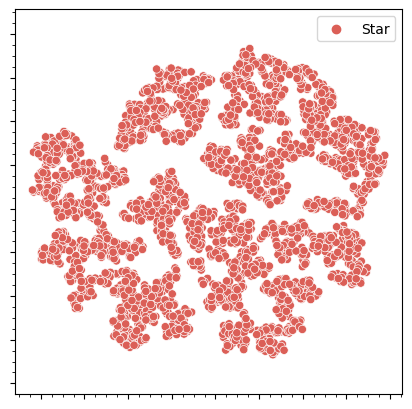

In [19]:
# Create a dataframe to store t-SNE results and corresponding class labels
df_tsne = pd.DataFrame()
df_tsne["class"] = y_train.to_numpy().astype(int)[0:15000]
df_tsne["comp-1"] = z_tsne_train[:,0]
df_tsne["comp-2"] = z_tsne_train[:,1]
# Replace numerical class labels with their respective class names
df_tsne = df_tsne.replace({'class': {0: 'Star', 1: 'Gal', 2: 'Qso'}})
print(df_tsne["class"].value_counts())

# Create a scatter plot of the t-SNE results, color-coded by class
plt.figure(figsize=(5, 5))
sfig = sns.scatterplot(x="comp-1", y="comp-2", hue=df_tsne["class"].tolist(),
            palette=sns.color_palette("hls", 3),
            data=df_tsne)
# Remove tick labels and axis labels for a cleaner plot
sfig.set(xticklabels=[])
sfig.set(yticklabels=[])
sfig.set(ylabel=None)
sfig.set(xlabel=None)
# Set the aspect ratio of the plot to be equal
plt.axis('equal')
# Add minor ticks to the plot
plt.minorticks_on()
# Display the plot
plt.show()

It's possible that there are no points plotted for Gal and Qso in the range of the x and y axis of the plot, or that there is an error in the code that I do not yet see.

It could be that the values in df_tsne["class"] are not evenly distributed across the three categories.
Checking the number of unique levels in df_tsne["class"] by using the unique() function:

In [20]:
print(df_tsne["class"].unique())

['Star']


As the output less than 3,(it only returns Star) then the other two categories are missing in the data?

In [21]:
df_tsne

,class,comp-1,comp-2
0,Star,8.160220,-2.663998
1,Star,-39.795002,-58.466793
2,Star,-34.361225,-2.932980
3,Star,44.466713,-18.119434
4,Star,43.564312,-40.561527
...,...,...,...
2709,Star,33.299759,-41.966785
2710,Star,58.255764,-2.734469
2711,Star,-72.504196,27.679495
2712,Star,-43.114483,-46.543503
